In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# function to predict num-col depending on other num-cols (not used in this notebook)

def predict_col(numericals:pd.DataFrame, column, features):
    # train-test-split and transform
    model_data = numericals.dropna(subset=[column])
    X = pd.DataFrame(model_data[features])
    y = model_data[column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    transformer = MinMaxScaler().fit(X_train)
    X_train_norm = transformer.transform(X_train)
    X_test_norm = transformer.transform(X_test)

    # build simple model and predict empty rows of target-column
    model = LogisticRegression()
    model.fit(X_train_norm, y_train)

    nans = numericals[numericals[column].isna()]
    not_nans = numericals.dropna(subset=[column])

    nans[column] = model.predict(
        transformer.transform(
            nans[features]))

    # r2-score for info
    print('R2:', r2_score(y_test, model.predict(X_test_norm)))
    numericals = pd.concat([nans, not_nans], axis=0)
    return numericals

In [2]:
# show the accumulated absolutes of correlations in a corr_mat depending on list of targets in 

def show_abs_corrs(corr_mat, targets):
    # calc for the first element of targets
    a = pd.DataFrame(corr_mat[targets[0]])
    a['abs_sum'] = abs(a[targets[0]])
    targets.remove(targets[0])

    # if more than 1 target, add abs(corr) to other targets
    for target in targets:
        a['abs_sum'] = a['abs_sum'] + abs(corr_mat[target])
        b = pd.DataFrame(corr_mat[target])
        a = pd.concat([a,b],axis=1)

    # sort the accumulated abs of corrs and show it
    c = pd.DataFrame(a['abs_sum']).sort_values(by='abs_sum', ascending=False)
    display(c.T)

In [3]:
# function to get corr_mat and also plot the corresponding heatmap

def get_collinearity(nums, target, graph=True):
    corr_mat = pd.concat([nums, target], axis=1).corr(method='pearson')
    if graph:
        mask=np.triu(np.ones_like(corr_mat, dtype=bool)) 
        plt.figure(figsize=(15,5))
        sns.heatmap(corr_mat, annot=True, mask=mask, fmt='.1f')
        plt.show
    
    return corr_mat   

In [4]:
# load in data

nums = pd.read_csv('files_for_lab/numerical.csv')
cats = pd.read_csv('files_for_lab/categorical.csv')
targets = pd.read_csv('files_for_lab/target.csv')

In [7]:
# scale numericals for feature-selection-techniques

scaler = MinMaxScaler().fit(nums)
nums_scaled = pd.DataFrame(scaler.transform(nums))
nums_scaled.columns = nums.columns

# set target
y = targets['TARGET_B']

In [8]:
# following steps get reapeated for different models

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

k = 33  # to end up with ~20 after multi-coll elimination
X = nums_scaled

kbest = SelectKBest(chi2, k=k).fit(X, y)

# select the k best features
df = pd.DataFrame(data = kbest.scores_, columns = ['score'])
df['Column'] = nums.columns
top20_kbest = df.sort_values(by = ['score'], ascending = False).head(k)
top20_kbest = top20_kbest['Column'].values

,TARGET_B,RFA_2F,CARDGIFT,NGIFTALL,NUMPROM,CARDPROM,HV2,HV1,HVP4,HVP3,HVP2,HVP1,HVP5,HHAS3,HV3,HV4,RP2,ETHC4,HVP6,RP1,ETH2,ETHC5,MHUC1,RP3,POBC2,HHAS4,IC15,INCOME,CLUSTER2,IC14,IC23,CONTROLN,MSA,HC6
abs_sum,1.0,0.072311,0.054027,0.050896,0.033161,0.032467,0.025607,0.025012,0.024186,0.024175,0.023514,0.022948,0.022034,0.020252,0.020191,0.020085,0.019928,0.019885,0.019869,0.019158,0.01904,0.018689,0.018195,0.017939,0.017562,0.017448,0.017081,0.016508,0.01639,0.014884,0.014821,0.013165,0.011018,0.010803


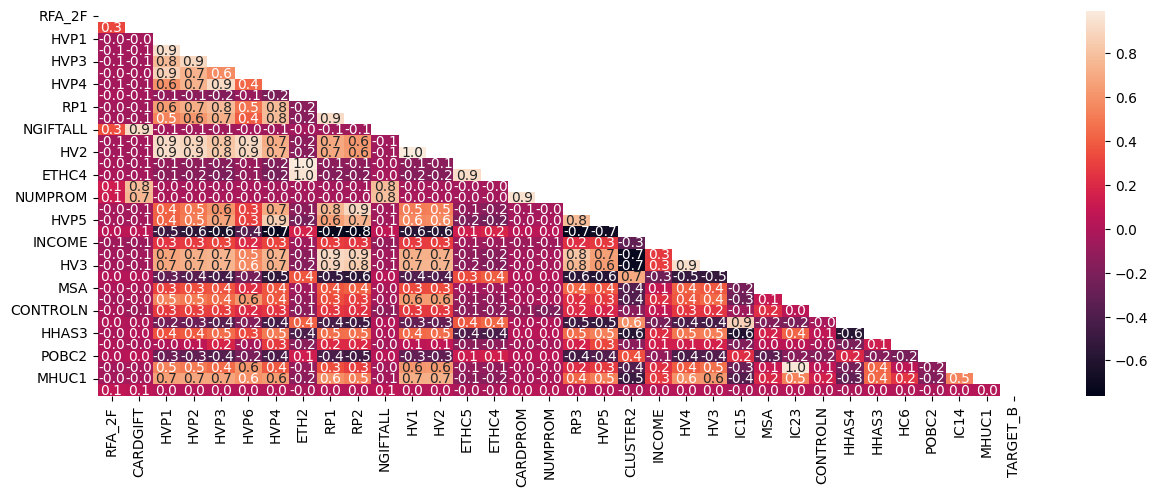

In [9]:
# make correlations and heatmap for dropping multicollinearity
corr_mat_kbest = get_collinearity(nums[top20_kbest], y, graph=True)
show_abs_corrs(corr_mat_kbest, ['TARGET_B'])#, 'TARGET_D'])

18

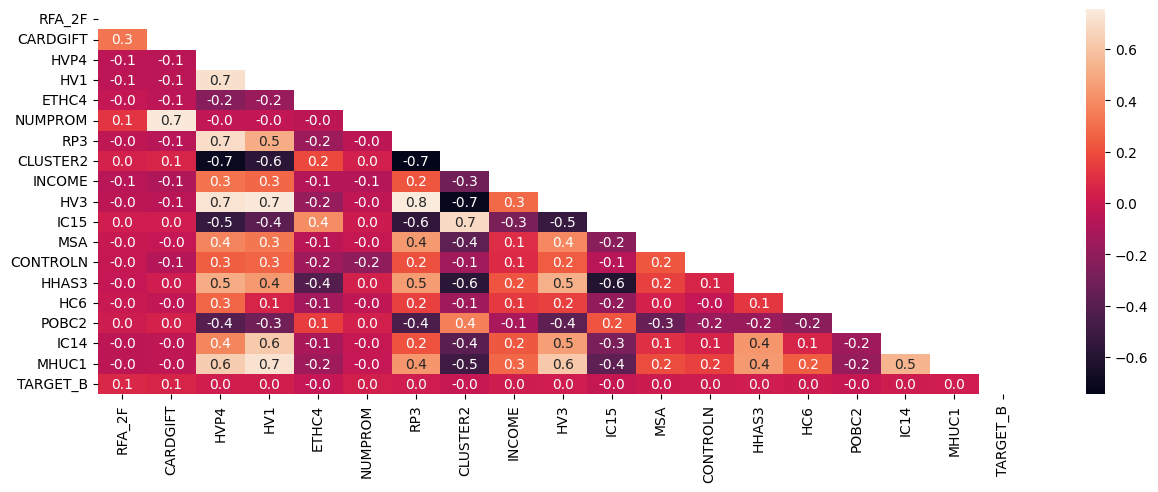

In [10]:
# drop multicollinearity
drop_cols_kbest = ['HVP1', 'HVP2', 'HVP3', 'HVP5', 'HVP6', 'ETHC5', 'ETH2', 'HV2', 'HV4', 'RP1', 'RP2', 'IC23', 'HHAS4','CARDPROM', 'NGIFTALL']
TOP_kbest = [col for col in top20_kbest if col not in drop_cols_kbest]
corr_mat_kbest = get_collinearity(nums[TOP_kbest], targets['TARGET_B'])
len(TOP_kbest)

In [11]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

rfe = RFE(LinearRegression(), n_features_to_select=20, verbose=False, step=20) # steps because i dont have the tiiiiiime 
rfe.fit(X, y)

df = pd.DataFrame(data = rfe.ranking_, columns=['Rank'])
df['Column_name'] = pd.DataFrame(nums).columns
top20_rfe = df[df['Rank']==1]
top20_rfe = top20_rfe['Column_name'].values

,TARGET_B,NGIFTALL,LASTGIFT,MAXRAMNT,RAMNTALL,TPE4,TPE3,HHD1,MC1,DW3,MC2,POP90C1,HUPA1,HHD8,POP90C3,TPE5,TPE6,DW4,HUPA2,POP90C2,DW5
abs_sum,1.0,0.050896,0.035526,0.016812,0.014651,0.012396,0.012178,0.010556,0.009578,0.007991,0.007134,0.005896,0.005832,0.004965,0.00495,0.004337,0.0038,0.002161,0.00138,0.001299,0.000512


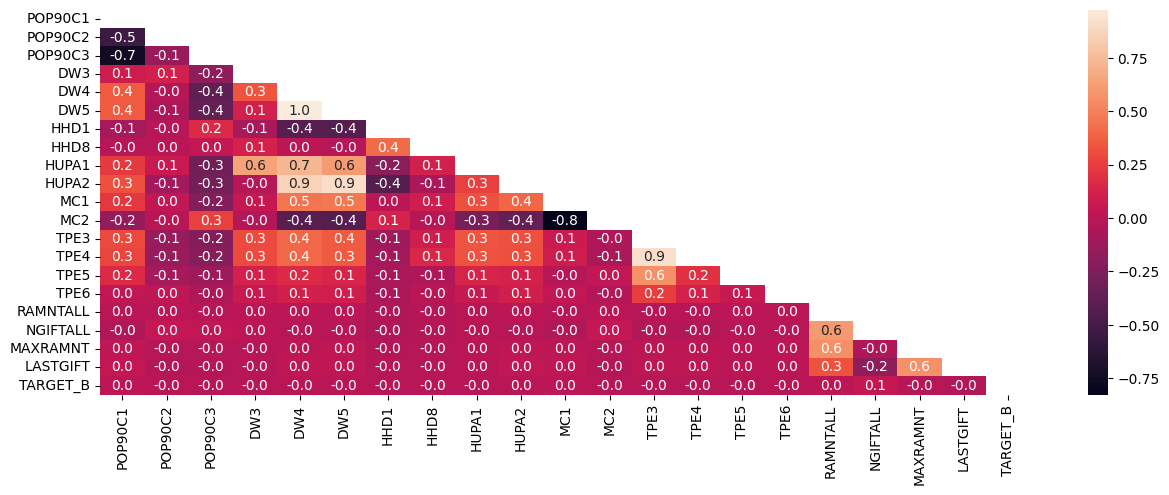

In [12]:
corr_mat_rfe = get_collinearity(nums[top20_rfe], y, graph=True)
show_abs_corrs(corr_mat_rfe, ['TARGET_B'])

18

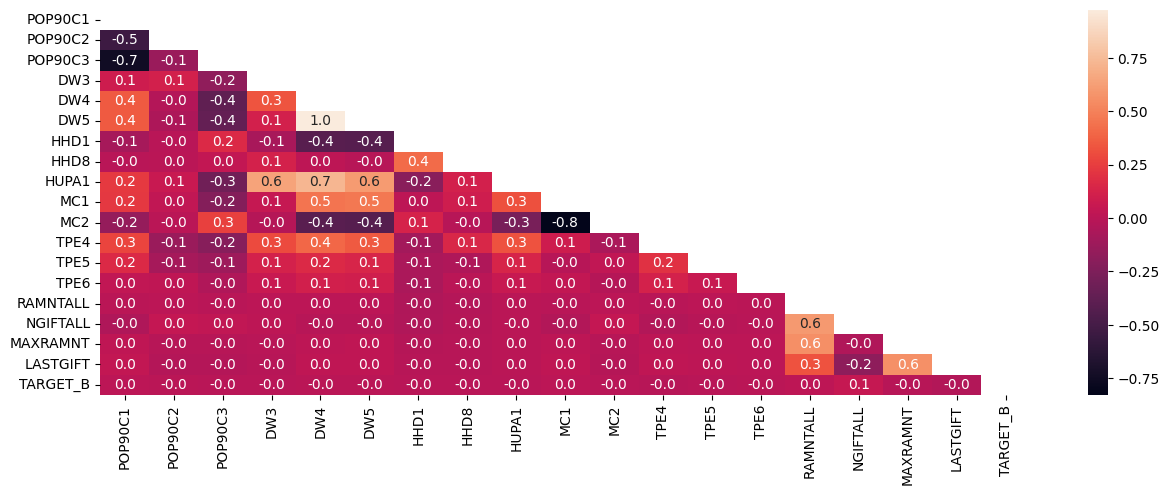

In [13]:
drop_cols_rfe = ['HUPA2', 'TPE3']
TOP_rfe = [col for col in top20_rfe if col not in drop_cols_rfe]
corr_mat_rfe = get_collinearity(nums[TOP_rfe], targets['TARGET_B'])
len(TOP_rfe)

In [14]:
from sklearn.feature_selection import VarianceThreshold 
var_threshold = 0.1
var = VarianceThreshold() # default is threshold = 0 :eliminate all coumns that are identical for all rows

var = var.fit(nums_scaled)
column_vars = pd.DataFrame(data=(nums.columns, var.variances_), index=('column_name','variance')).T 

top20_var = column_vars.sort_values(by='variance', ascending=False).head(20)
top20_var = top20_var['column_name'].values

,TARGET_B,RFA_2F,HVP4,HVP3,HVP2,RP2,RP1,RP3,CLUSTER2,HC6,HC7,HC8,POP90C1,POP90C3,HC19,LFC9,HPHONE_D,LFC8,POP90C2,HC11,WEALTH2
abs_sum,1.0,0.072311,0.024186,0.024175,0.023514,0.019928,0.019158,0.017939,0.01639,0.010803,0.010363,0.009124,0.005896,0.00495,0.003551,0.003238,0.002626,0.00189,0.001299,0.000666,0.000107


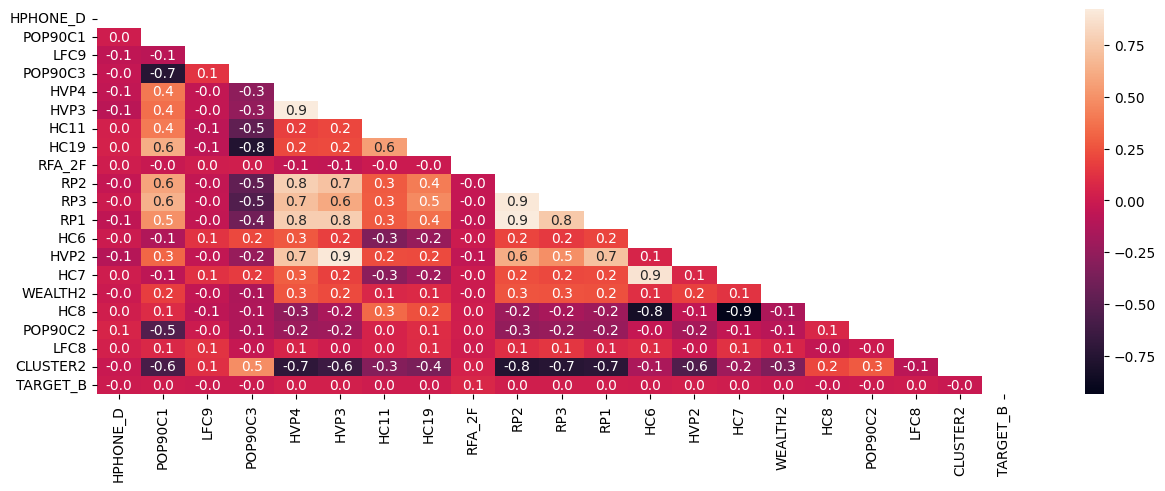

In [15]:
corr_mat_var = get_collinearity(nums[top20_var], y, graph=True)
show_abs_corrs(corr_mat_var, ['TARGET_B'])

17

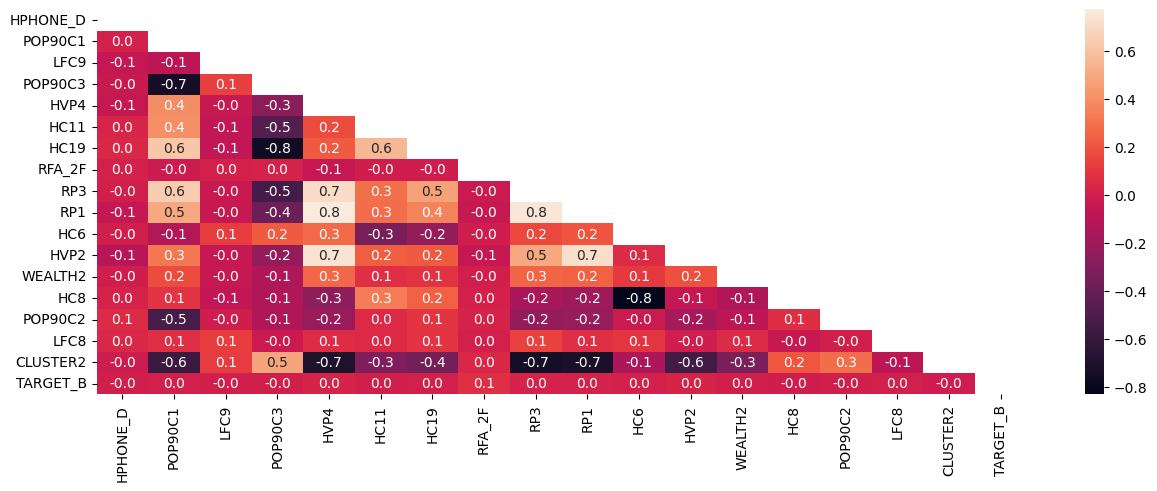

In [16]:
drop_cols_var = ['RP2', 'HC7', 'HP3', 'HVP3']
TOP_var = [col for col in top20_var if col not in drop_cols_var]
corr_mat_var = get_collinearity(nums[TOP_var], targets['TARGET_B'])
len(TOP_var)

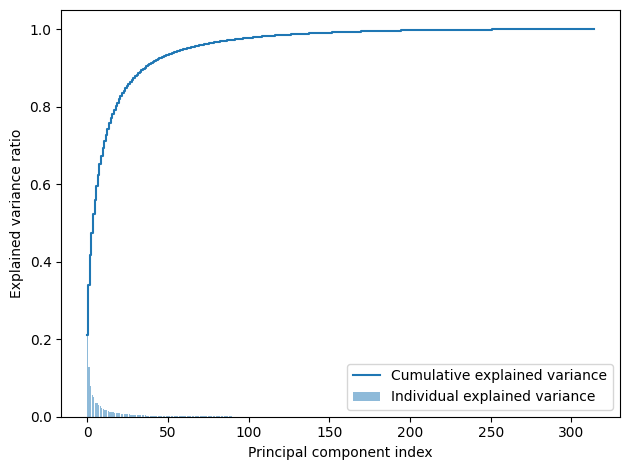

In [17]:
# PCA

from sklearn.decomposition import PCA

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(nums_scaled, y)

pca = PCA()
pca.fit(nums_scaled)

# Cumulative sum of eigenvalues; This will be used to create step plot
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, 
        alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, 
         where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [18]:
# cumulative explained variance of >= 0.9
pca = PCA(0.8)
pca.fit(nums_scaled)

PCA(n_components=0.8)

In [19]:
# number of principal components
len(pca.explained_variance_ratio_)

19

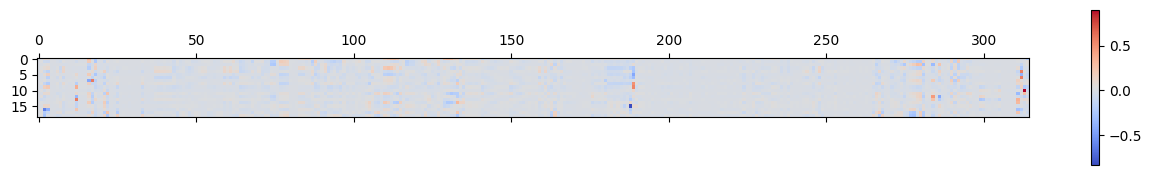

In [20]:
plt.matshow(pca.components_, cmap='coolwarm')
# plt.yticks([0,1,2,3,4,5],['1st Comp','2nd Comp','3rd Comp','4th','5th','6th'],fontsize=10)
# plt.xticks(range(len(nums.columns)),nums.columns,rotation=65,ha='left')
plt.colorbar()
plt.tight_layout()
plt.show()

In [21]:
X_train_pca = pd.DataFrame(pca.transform(X_train_scaled))
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled))
nums_pca = pd.concat([X_train_pca, X_test_pca], axis=0)

In [23]:
# save numericals with diff features to csv

nums_kbest = nums[TOP_kbest]
nums_rfe = nums[TOP_rfe]
nums_var = nums[TOP_var]

nums_kbest.to_csv('files_for_lab/kbest_nums.csv', index=False)
nums_rfe.to_csv('files_for_lab/rfe_nums.csv', index=False)
nums_var.to_csv('files_for_lab/var_nums.csv', index=False)
nums_pca.to_csv('files_for_lab/pca_nums.csv', index=False)